In [1]:
import pylab as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin,BaseEstimator
from datetime import datetime
from datetime import date
import scipy.stats as stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_palette("mako")

### Načítanie a čistenie dát

In [2]:
stations= pd.read_csv("data/stations.csv", sep="\t")
measurements= pd.read_csv("data/measurements.csv", sep="\t")

In [3]:
measurements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12128 entries, 0 to 12127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       12080 non-null  float64
 1   PM10       12079 non-null  float64
 2   C2H3NO5    12079 non-null  float64
 3   O3         12079 non-null  float64
 4   NH3        12080 non-null  float64
 5   Pb         12079 non-null  float64
 6   PRES       12128 non-null  float64
 7   CFCs       12079 non-null  float64
 8   longitude  12128 non-null  float64
 9   SO2        12079 non-null  float64
 10  latitude   12128 non-null  float64
 11  NOx        12078 non-null  float64
 12  warning    12079 non-null  float64
 13  CO         12079 non-null  float64
 14  CH4        12079 non-null  float64
 15  PM2.5      12080 non-null  float64
 16  H2CO       12080 non-null  float64
 17  TEMP       12080 non-null  float64
dtypes: float64(18)
memory usage: 1.7 MB


In [4]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    1051 non-null   object 
 1   latitude   1051 non-null   float64
 2   code       1050 non-null   object 
 3   revision   1051 non-null   object 
 4   QoS        1051 non-null   object 
 5   longitude  1051 non-null   float64
dtypes: float64(2), object(4)
memory usage: 49.4+ KB


Skontrolujeme, či sú jednotlivé 'latitude' jedinečné, a podľa nich joineme.

In [5]:
latitude_s = stations["latitude"].unique().sort()
latitude_m = measurements["latitude"].unique().sort()
np.array_equal(latitude_s, latitude_m)

True

Sú rovnaké, preto môžeme ich spojiť. Taktiež odstránime duplicitný stĺpec ktorý nám vznikne.

In [6]:
data = pd.merge(measurements, stations, on = ["latitude"], how = "left")
data.drop(columns=["longitude_x"], inplace=True)
data.rename(columns={'longitude_y': 'longitude'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25540 entries, 0 to 25539
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       25447 non-null  float64
 1   PM10       25437 non-null  float64
 2   C2H3NO5    25444 non-null  float64
 3   O3         25435 non-null  float64
 4   NH3        25448 non-null  float64
 5   Pb         25435 non-null  float64
 6   PRES       25540 non-null  float64
 7   CFCs       25447 non-null  float64
 8   SO2        25434 non-null  float64
 9   latitude   25540 non-null  float64
 10  NOx        25443 non-null  float64
 11  warning    25427 non-null  float64
 12  CO         25437 non-null  float64
 13  CH4        25442 non-null  float64
 14  PM2.5      25434 non-null  float64
 15  H2CO       25443 non-null  float64
 16  TEMP       25438 non-null  float64
 17  station    25540 non-null  object 
 18  code       25529 non-null  object 
 19  revision   25540 non-null  object 
 20  QoS   

Ukážka dát po spojení.

In [7]:
data.head()

,PAHs,PM10,C2H3NO5,O3,NH3,Pb,PRES,CFCs,SO2,latitude,...,CO,CH4,PM2.5,H2CO,TEMP,station,code,revision,QoS,longitude
0,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,...,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,PG,26 Sep 2019,average,144.23058
1,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,...,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,PG,17 Dec 2021,average,144.23058
2,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,...,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,PG,17 Mar 2016,good,144.23058
3,10.39372,8.25541,1.19707,8.98772,9.82297,47.15361,1063.43896,69.62954,8.29285,8.88649,...,8.47772,9.60717,7.09990,65.37280,13.19832,Tchaourou,BJ,12 Mar 2015,good,2.59753
4,9.56441,8.43278,1.32137,4.43270,8.08426,47.94224,1111.55551,77.84035,8.42276,10.10649,...,8.97045,8.89398,8.22953,47.62991,3.92248,Alwaye,IN,30 May 2021,average,76.35484


Upravíme si formát dátumu v stĺpci revision

In [8]:
data[["revision"]]=data[["revision"]].apply(pd.to_datetime)

In [9]:
data.QoS.unique()

array(['average', 'good', 'excellent', 'maintenance', 'accep', 'building',
       'maitennce', 'acceptable'], dtype=object)

In [10]:
data.loc[data['QoS'] == 'accep','QoS']='acceptable'
data.loc[data['QoS'] == 'maitennce','QoS']='maintenance'
data.QoS.unique()

array(['average', 'good', 'excellent', 'maintenance', 'acceptable',
       'building'], dtype=object)

Odstránime duplicitné záznamy

In [11]:
tmp = data.duplicated()
tmp = tmp[tmp == True].count()
print('Počet duplicitných záznamov: '+ str(tmp))

Počet duplicitných záznamov: 362


In [12]:
data = data.drop_duplicates()
tmp = data.duplicated()
tmp = tmp[tmp == True].count()
print('Počet duplicitných záznamov: '+ str(tmp))

Počet duplicitných záznamov: 0


In [13]:
data.describe()

,PAHs,PM10,C2H3NO5,O3,NH3,Pb,PRES,CFCs,SO2,latitude,NOx,warning,CO,CH4,PM2.5,H2CO,TEMP,longitude
count,25085.000000,25079.000000,25084.000000,25077.000000,25086.000000,25075.000000,25178.000000,25087.000000,25075.000000,25178.000000,25084.000000,25069.000000,25079.000000,25082.000000,25072.000000,25081.000000,25076.000000,25178.000000
mean,8.796943,8.789140,3.338692,9.307207,8.794920,49.811586,1125.132951,72.141103,8.815813,28.503626,9.316199,0.596514,8.796864,9.311465,8.780185,50.820606,14.887810,7.262204
std,2.080231,0.994905,4.117469,1.905605,0.992425,12.753109,43.420165,7.168527,1.948870,23.500745,1.687569,0.490606,1.005002,1.906974,2.086149,13.978825,9.943023,71.021243
min,1.925340,5.187260,0.000000,2.048720,5.124910,0.000000,1050.000710,0.000000,1.029620,-54.800000,2.304540,0.000000,5.032870,2.492000,0.000000,0.000000,-26.219360,-156.474320
25%,7.338250,8.126365,1.190090,8.110560,8.122707,41.312785,1087.243540,67.355870,7.431870,13.445810,8.374120,0.000000,8.125095,8.029330,7.295268,41.514300,8.052570,-60.473890
50%,8.866290,8.789270,2.116440,9.469000,8.797590,49.715720,1125.722345,72.192360,8.983270,36.063860,9.642080,1.000000,8.805250,9.425030,8.628740,50.732260,14.863260,5.062580
75%,10.280750,9.454925,3.910400,10.642350,9.456315,58.356090,1162.787523,77.011540,10.212860,45.446940,10.476140,1.000000,9.468430,10.654855,10.286200,60.250430,21.693370,60.702780
max,17.068470,12.750440,100.000000,15.619060,12.763030,100.000000,1199.974700,100.000000,15.856800,68.798330,14.915300,1.000000,12.576710,16.569680,16.646230,100.000000,52.722610,178.004170


### Odstránenie NA hodnôt
Ako prvé skúsime metódu s odstránením riadkov, kde chýbajú hodnoty.

In [14]:
data['code']= data['code'].fillna('NO_CODE')
tmp_data = data.copy()
tmp_data.dropna(inplace=True)

In [15]:
len(data) - len(tmp_data)

1444

C:\Users\valen\AppData\Local\Temp\ipykernel_18972\389424590.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');


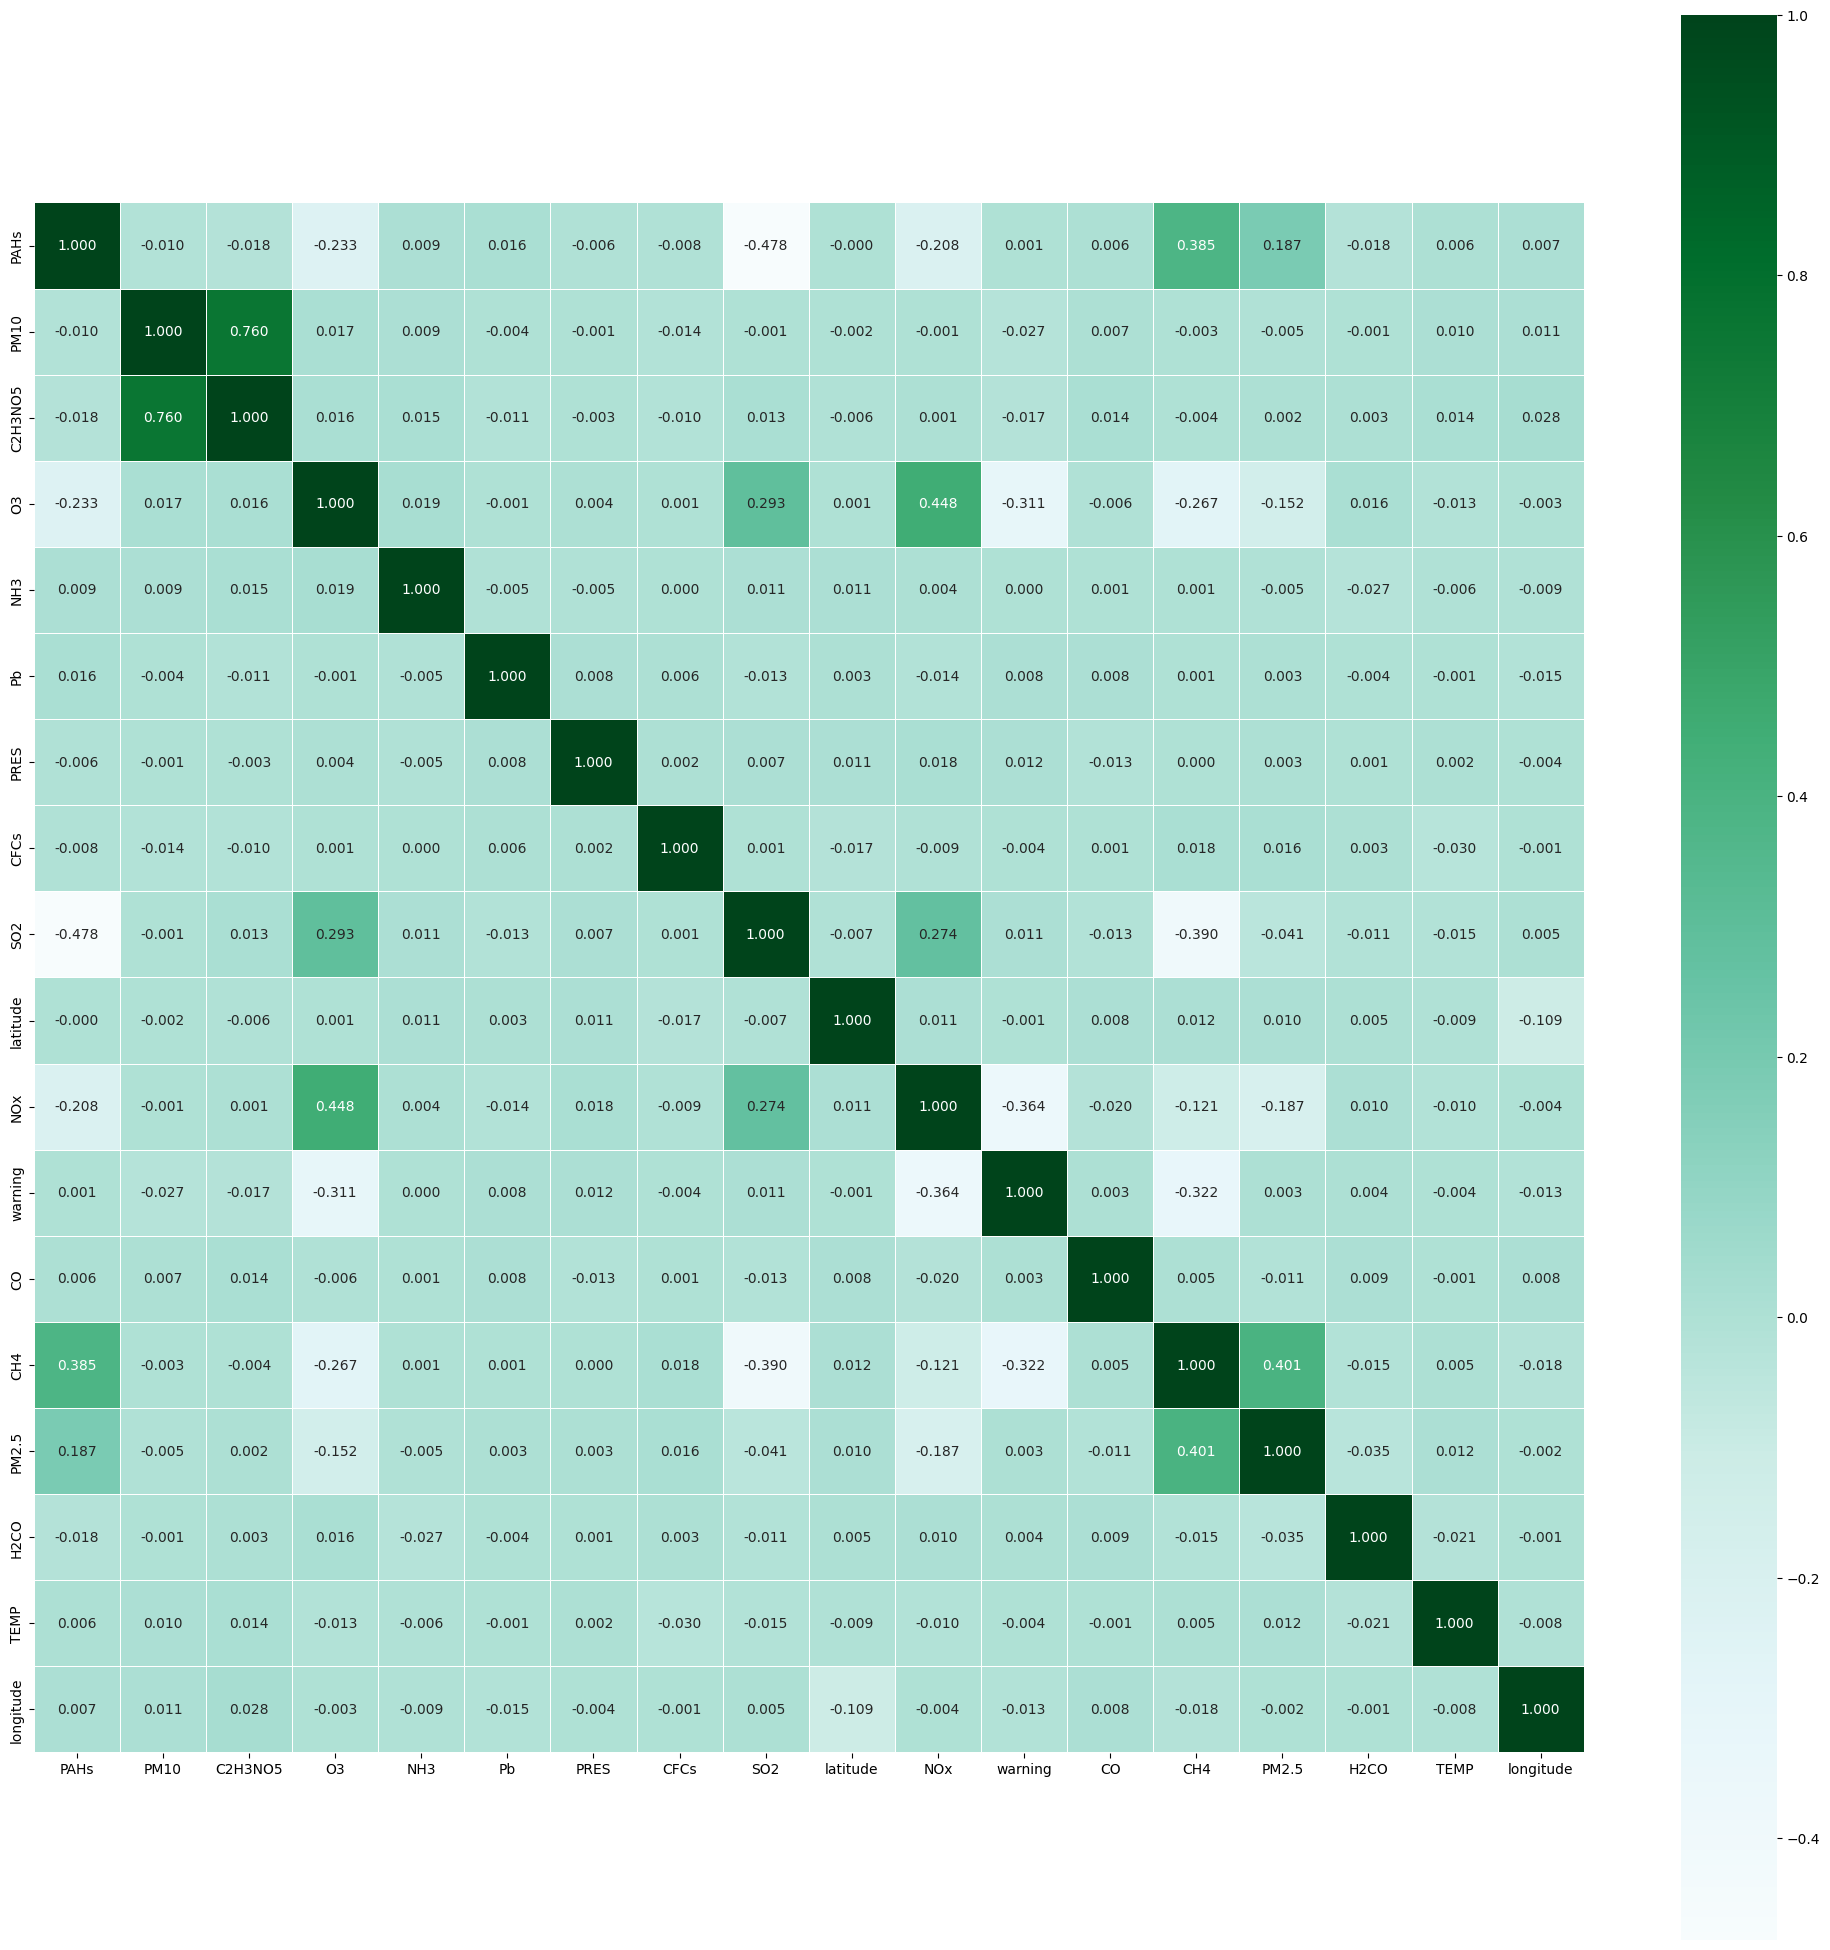

In [16]:
plt.figure(figsize=(25,25))
sns.heatmap(data.corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

C:\Users\valen\AppData\Local\Temp\ipykernel_18972\299928036.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(tmp_data.corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');


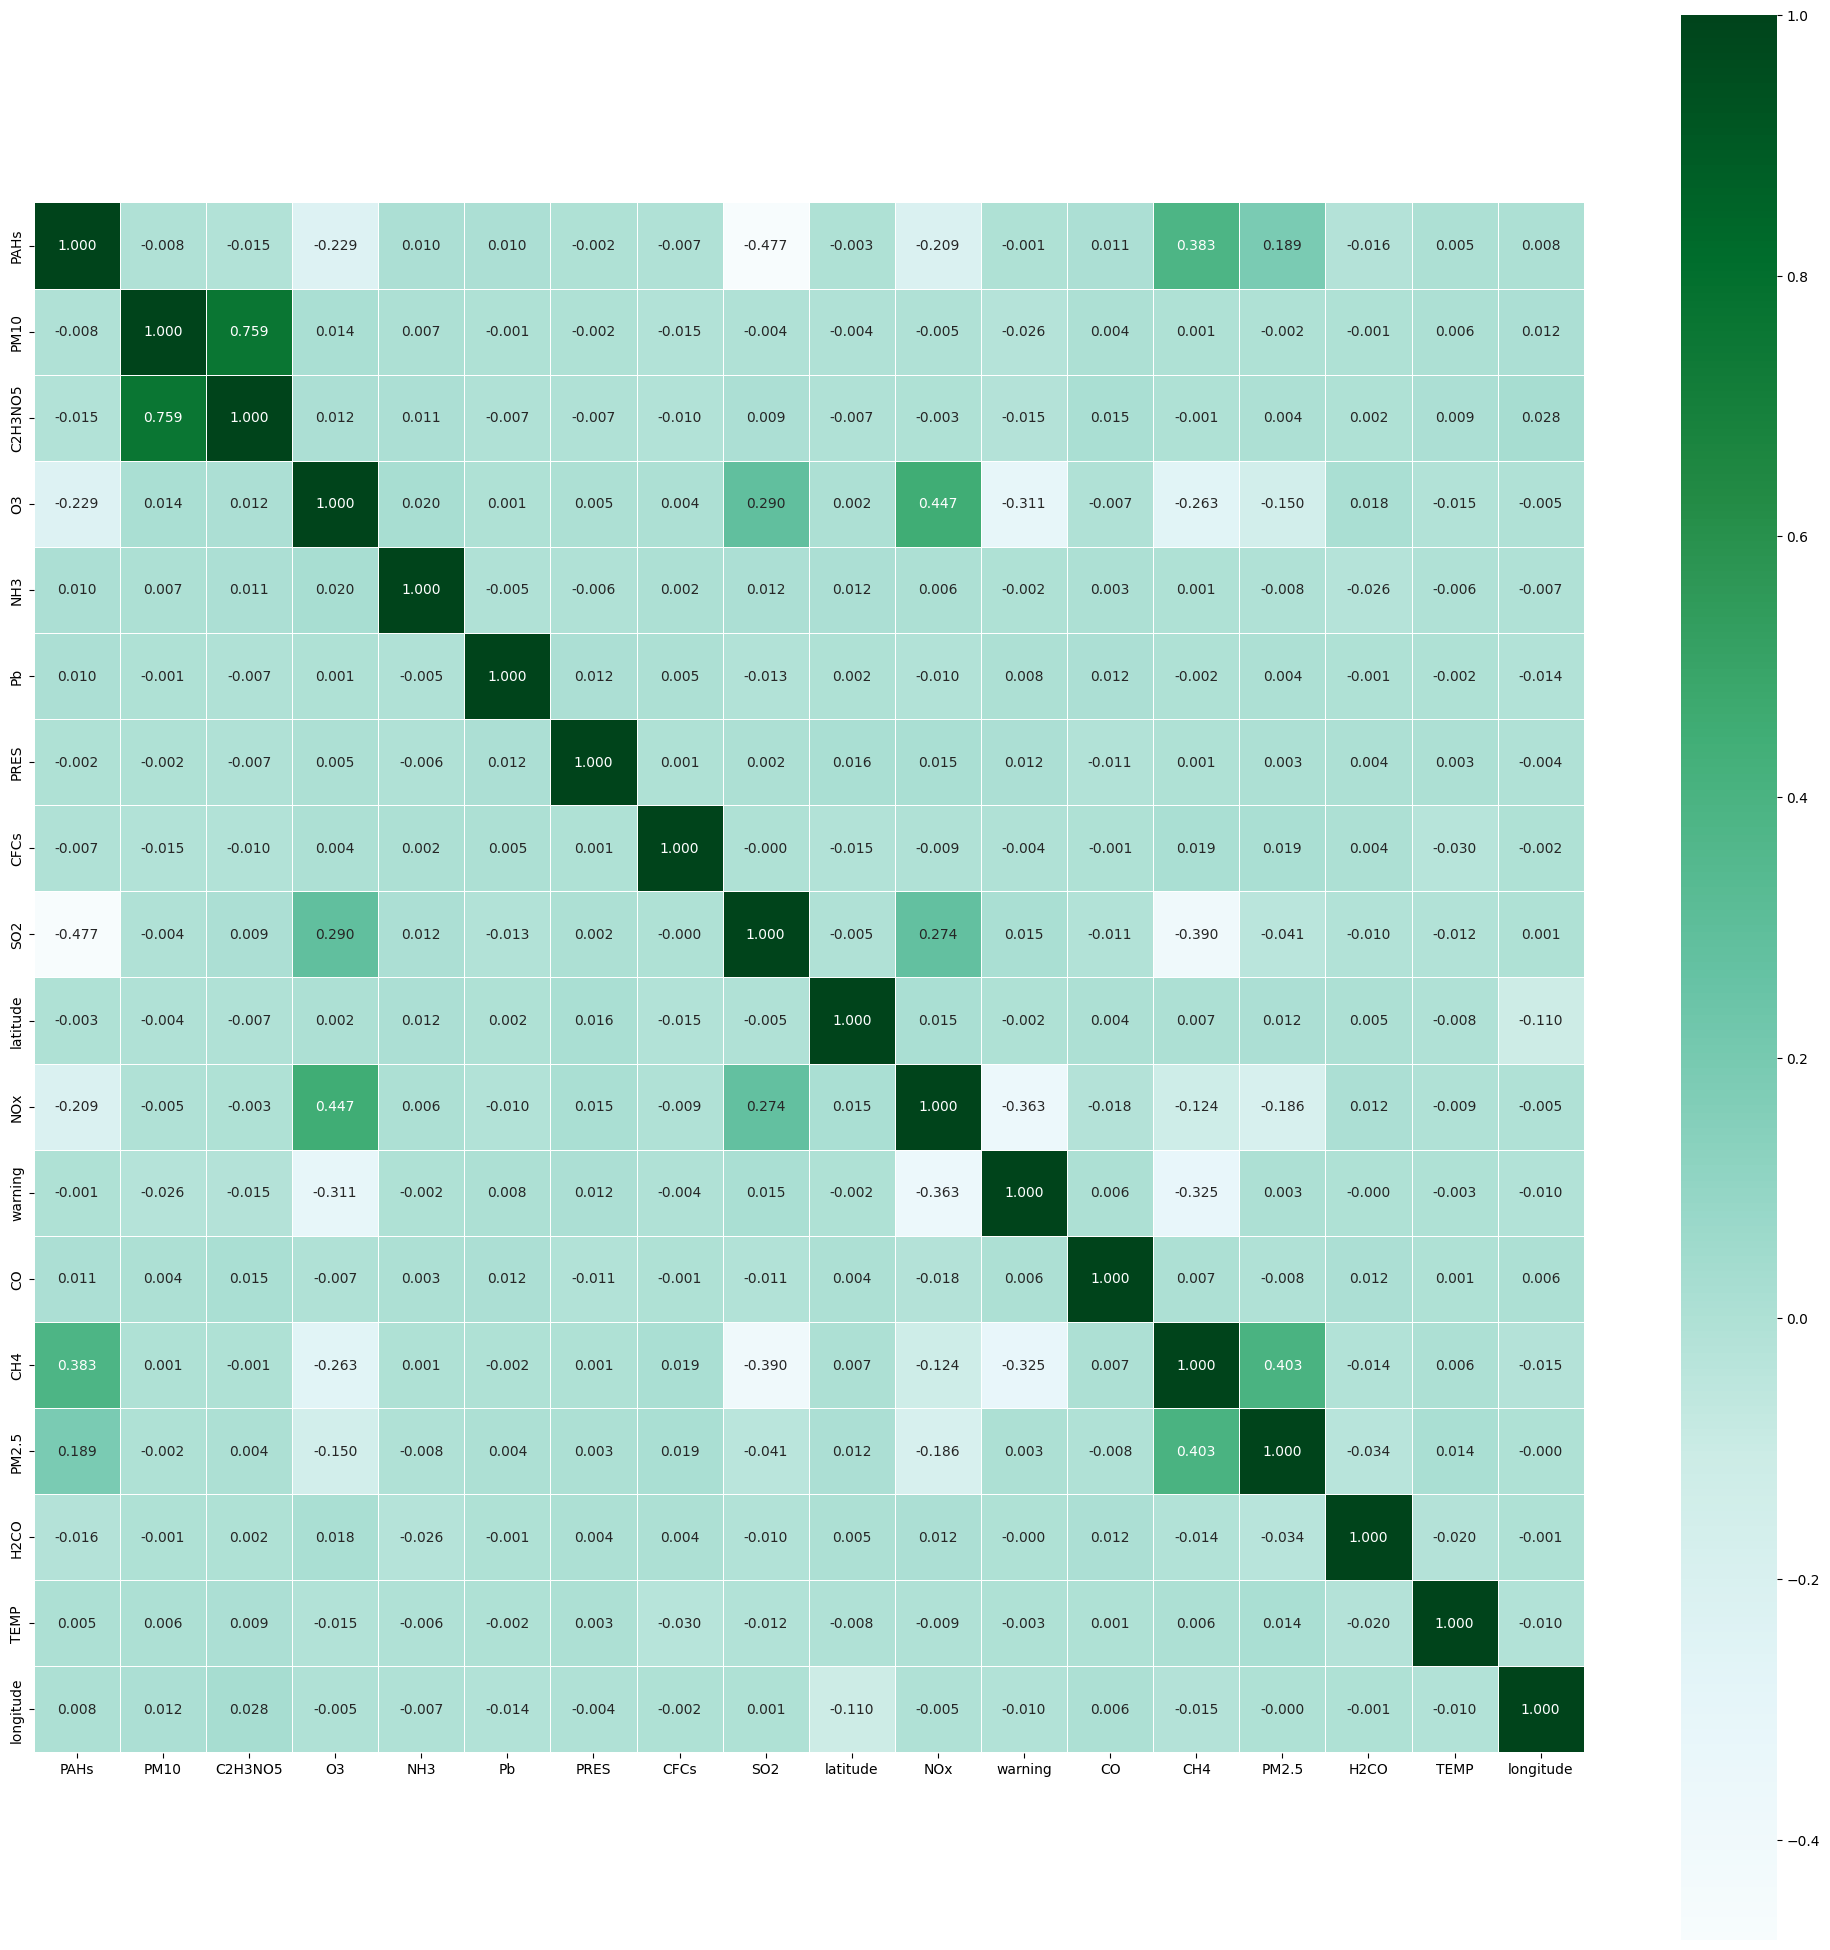

In [17]:
plt.figure(figsize=(25,25))
sns.heatmap(tmp_data.corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

Výhodou tohto prístupu je, že sa nám heatmapa zmenila len minimálne. Nevýhodou je, že nám zmizlo 1454 záznamov.
To nám predstavuje 5.78% dát.

In [18]:
(len(data)-len(tmp_data))/(len(data)) * 100

5.735165620780045